# Анализ фондового рынка. 

<b>Описание проекта</b><br>
Из импортированных файлов  с информацией о динамике цен акций на фондовом рынке необходимо собрать датафрейм, осуществить предобработку, добавить метрики и провести исследовательский анализ цены за последние 3 года. В исследовании использовать скользящие средние, экспотенциальные скользящие средние и RSI индикатор.



**Задание**
1. Загрузите информацию об акциях (не менее пяти тикеров) с сайте finam.ru с параметрами:
Интервал: 3 года, периодичность 1 день.
Формат записи в файл:
<TICKER>	<PER>	<DATE>	<TIME>	<OPEN>	<HIGH>	<LOW>	<CLOSE>	<VOL>
https://www.finam.ru/quote/moex/gazp/export/
2. Соберите информацию из файлов в единый датафрейм (используйте дополнительные библиотеки).
3. Осуществите предобработку дат и заголовков.
4. Постройте линейные графики динамики цены для каждой акции (реализуйте в цикле).
5. Для каждой акции найдите дни максимального изменения цены (взлета и падения). Составьте отчет.
6. Найдите скользящие средние (периоды 10, 50, 100) для каждой акции. Добавьте на график.
7. Постройте в цикле графики объема (volume) для каждого тикера.
8. Реализуйте в цикле для каждого тикера последовательно: график цены вместе с скользящими средними с периодом 50, 100 и график объема, реализуйте с помощью функции. На вход функция принимает два параметра: тикер и год.
9. Добавьте экспоненциальные скользящие средние для каждого тикера с периодом 50.
10. Осуществите расчет индикатора RSI.
11.  Создайте функцию для вывода графиков: цены, скользящей средней (тип и период определите самостоятельно) и отдельный график для RSI индикатора. На графике с RSI добавьте две красные линии на уровнях 70 и 30. На вход функция принимает два параметра: тикер и год. <br>

Работу сопроводите комментариями к коду и выводами. 

**Дополнительная задача**<br>
Постройте модель прогноза цены акции

**Дополнительная информация**
1. Экпорт файлов осуществите с сайта:
https://www.finam.ru/quote/moex/gazp/export/
2. Для получения файлов из заданной директории используйте:

import glob<br>
globbed_files = glob.glob(path) # список файлов<br>

3. Информация про индикатор RSI
на БКС Экспресс:<br>
https://bcs-express.ru/novosti-i-analitika/indeks-otnositel-noi-sily-rsi-relative-strength-index<br>
Почитать еще про RSI:<br>
https://ru.tradingview.com/chart/BTCUSD/Eq8tysZA-indikator-rsi-sekrety-torgovli-pravila-primeneniya-polnyj-razbor/

3. Допустима загрузка исторических данных с помощью tinkoff invest api вместо экспорта с finam.ru

**Дополнительная задача**<br>
Постройте модель прогноза цены акции

### 1. Загрузите информацию об акциях (не менее пяти тикеров) с сайте finam.ru с параметрами: Интервал: 3 года, периодичность 1 день. Формат записи в файл: https://www.finam.ru/quote/moex/gazp/export/

In [331]:
# импортируем библиотеки:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LassoCV, RidgeCV
import statsmodels.api as sm
import warnings
import glob

In [332]:
path = '*.csv'
globbed_files = glob.glob(path)

In [333]:
print("Найденные файлы:", globbed_files)

Найденные файлы: ['газпром.csv', 'детский мир.csv', 'камаз.csv', 'лента.csv', 'сбер.csv']


### 2.Соберите информацию из файлов в единый датафрейм (используйте дополнительные библиотеки).

In [334]:
columns = ['<TICKER>', '<PER>', '<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']
df = pd.DataFrame(columns=columns)
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>


In [335]:
for file in globbed_files:
    file = pd.read_csv(file, sep=',', parse_dates=['<DATE>'], dayfirst=True)
    df = pd.concat([df, file])

In [336]:
df = df.reset_index(drop=True)
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,GAZP,D,2020-12-25 00:00:00,00:00:00,208.54,209.96,203.15,206.24,59081790
1,GAZP,D,2020-12-26 00:00:00,00:00:00,206.2,206.73,204.01,205.03,16517780
2,GAZP,D,2020-12-29 00:00:00,00:00:00,205.53,207.86,205.15,206.11,35038710
3,GAZP,D,2020-12-30 00:00:00,00:00:00,206.95,210.0,206.61,208.75,42353620
4,GAZP,D,2020-12-31 00:00:00,00:00:00,209.88,213.38,209.5,212.98,74667210
...,...,...,...,...,...,...,...,...,...
3459,SBER,D,2023-12-19 00:00:00,00:00:00,268.9,270.44,266.54,268.4,51515190
3460,SBER,D,2023-12-20 00:00:00,00:00:00,268.35,269.71,265.0,267.35,38229660
3461,SBER,D,2023-12-21 00:00:00,00:00:00,267.52,269.1,266.2,266.61,30929220
3462,SBER,D,2023-12-22 00:00:00,00:00:00,266.55,266.87,263.5,265.19,33214370


In [337]:
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,GAZP,D,2020-12-25 00:00:00,00:00:00,208.54,209.96,203.15,206.24,59081790
1,GAZP,D,2020-12-26 00:00:00,00:00:00,206.2,206.73,204.01,205.03,16517780
2,GAZP,D,2020-12-29 00:00:00,00:00:00,205.53,207.86,205.15,206.11,35038710
3,GAZP,D,2020-12-30 00:00:00,00:00:00,206.95,210.0,206.61,208.75,42353620
4,GAZP,D,2020-12-31 00:00:00,00:00:00,209.88,213.38,209.5,212.98,74667210
...,...,...,...,...,...,...,...,...,...
3459,SBER,D,2023-12-19 00:00:00,00:00:00,268.9,270.44,266.54,268.4,51515190
3460,SBER,D,2023-12-20 00:00:00,00:00:00,268.35,269.71,265.0,267.35,38229660
3461,SBER,D,2023-12-21 00:00:00,00:00:00,267.52,269.1,266.2,266.61,30929220
3462,SBER,D,2023-12-22 00:00:00,00:00:00,266.55,266.87,263.5,265.19,33214370


In [338]:
df = df.sort_values(by=['<DATE>', '<TICKER>']).reset_index(drop=True)
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,DSKY,D,2020-12-25 00:00:00,00:00:00,143.88,145.7,143.6,144.58,6423010
1,GAZP,D,2020-12-25 00:00:00,00:00:00,208.54,209.96,203.15,206.24,59081790
2,KMAZ,D,2020-12-25 00:00:00,00:00:00,64.0,64.2,60.8,62.8,65370
3,SBER,D,2020-12-25 00:00:00,00:00:00,271.9,272.82,267.13,269.32,42447420
4,DSKY,D,2020-12-26 00:00:00,00:00:00,139.54,142.96,139.1,140.48,5078850
...,...,...,...,...,...,...,...,...,...
3459,DSKY,D,2023-12-23 00:00:00,00:00:00,61.42,61.78,61.0,61.14,45820
3460,GAZP,D,2023-12-23 00:00:00,00:00:00,161.92,163.2,161.62,162.09,15391770
3461,KMAZ,D,2023-12-23 00:00:00,00:00:00,198.5,201.2,196.7,197.7,968630
3462,MOEX.LENT:TQBR,D,2023-12-23 00:00:00,00:00:00,666.5,688.0,665.5,679.5,70362


In [339]:
df = df.drop(columns=['<PER>', '<TIME>'])
df

,<TICKER>,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,DSKY,2020-12-25 00:00:00,143.88,145.7,143.6,144.58,6423010
1,GAZP,2020-12-25 00:00:00,208.54,209.96,203.15,206.24,59081790
2,KMAZ,2020-12-25 00:00:00,64.0,64.2,60.8,62.8,65370
3,SBER,2020-12-25 00:00:00,271.9,272.82,267.13,269.32,42447420
4,DSKY,2020-12-26 00:00:00,139.54,142.96,139.1,140.48,5078850
...,...,...,...,...,...,...,...
3459,DSKY,2023-12-23 00:00:00,61.42,61.78,61.0,61.14,45820
3460,GAZP,2023-12-23 00:00:00,161.92,163.2,161.62,162.09,15391770
3461,KMAZ,2023-12-23 00:00:00,198.5,201.2,196.7,197.7,968630
3462,MOEX.LENT:TQBR,2023-12-23 00:00:00,666.5,688.0,665.5,679.5,70362


In [340]:
#столбец с датой лучше вынести на первую линию, так удобнее
df.insert(0, '<DATE>', df.pop('<DATE>'))
df

,<DATE>,<TICKER>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2020-12-25 00:00:00,DSKY,143.88,145.7,143.6,144.58,6423010
1,2020-12-25 00:00:00,GAZP,208.54,209.96,203.15,206.24,59081790
2,2020-12-25 00:00:00,KMAZ,64.0,64.2,60.8,62.8,65370
3,2020-12-25 00:00:00,SBER,271.9,272.82,267.13,269.32,42447420
4,2020-12-26 00:00:00,DSKY,139.54,142.96,139.1,140.48,5078850
...,...,...,...,...,...,...,...
3459,2023-12-23 00:00:00,DSKY,61.42,61.78,61.0,61.14,45820
3460,2023-12-23 00:00:00,GAZP,161.92,163.2,161.62,162.09,15391770
3461,2023-12-23 00:00:00,KMAZ,198.5,201.2,196.7,197.7,968630
3462,2023-12-23 00:00:00,MOEX.LENT:TQBR,666.5,688.0,665.5,679.5,70362


### 3. Осуществите предобработку дат и заголовков. 

In [341]:
#изменим название столбцов
df.columns = ['date', 'ticker', 'open', 'high', 'low', 'close', 'vol']
df.head(1)

,date,ticker,open,high,low,close,vol
0,2020-12-25 00:00:00,DSKY,143.88,145.7,143.6,144.58,6423010


In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3464 entries, 0 to 3463
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3464 non-null   object
 1   ticker  3464 non-null   object
 2   open    3464 non-null   object
 3   high    3464 non-null   object
 4   low     3464 non-null   object
 5   close   3464 non-null   object
 6   vol     3464 non-null   object
dtypes: object(7)
memory usage: 189.6+ KB


Почему-то дата не отобразилась в формате datatime, сделаем тогда вручную

In [343]:
#поменяем формат с датой
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%dT%H:%M:%S') #изменим тип данных для  столбца, применим нужный формат

In [344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3464 entries, 0 to 3463
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3464 non-null   datetime64[ns]
 1   ticker  3464 non-null   object        
 2   open    3464 non-null   object        
 3   high    3464 non-null   object        
 4   low     3464 non-null   object        
 5   close   3464 non-null   object        
 6   vol     3464 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 189.6+ KB


Теперь по дате всё хорошо

In [345]:
#поменяем формат столбца с объёмом
df['vol'] = df['vol'].astype('int')

In [346]:
#поменяем форматы ещё некоторых столбцов 
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)

In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3464 entries, 0 to 3463
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3464 non-null   datetime64[ns]
 1   ticker  3464 non-null   object        
 2   open    3464 non-null   float64       
 3   high    3464 non-null   float64       
 4   low     3464 non-null   float64       
 5   close   3464 non-null   float64       
 6   vol     3464 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(1), object(1)
memory usage: 176.0+ KB


### 4. Постройте линейные графики динамики цены для каждой акции (реализуйте в цикле).

In [348]:
#выведем уникальные значения
ticker = df['ticker'].unique()
ticker

array(['DSKY', 'GAZP', 'KMAZ', 'SBER', 'MOEX.LENT:TQBR'], dtype=object)

Изменим названия акций на русские

In [349]:
ticker_2 = ['Детский мир', 'Газпром', 'КАМАЗ', 'СберБанк', 'Лента']

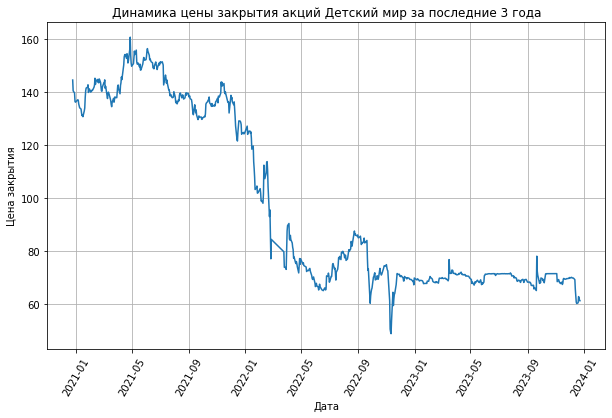

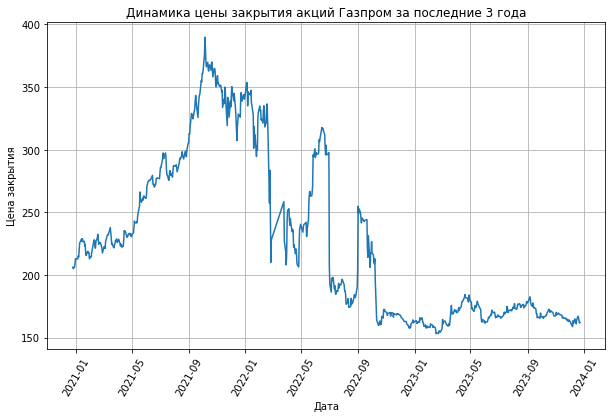

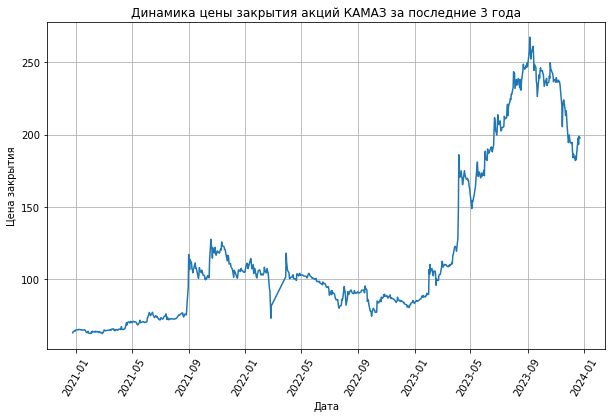

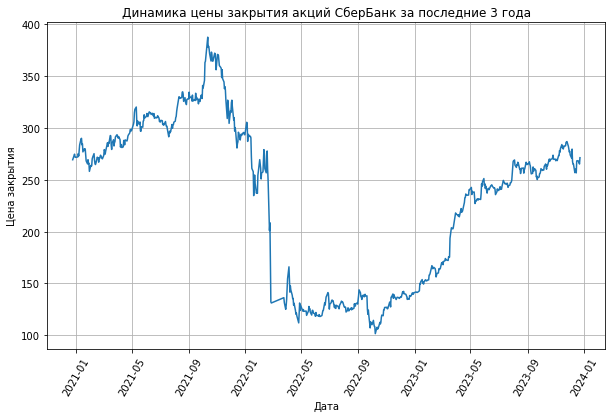

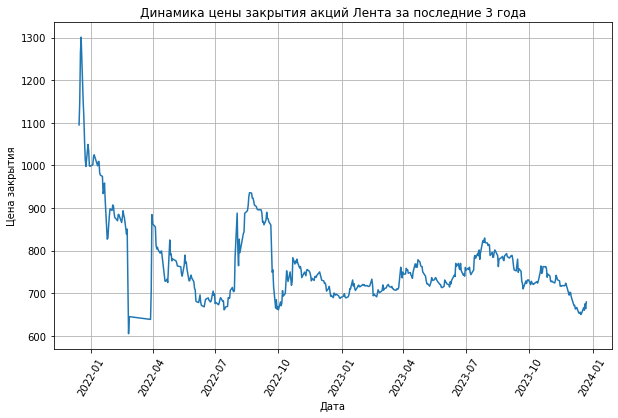

In [350]:
for i, p in enumerate(ticker):
    plt.figure(figsize = (10, 6))
    
    sns.lineplot(data=df.query('ticker == @p'), x='date', y='close')
    plt.title(f'Динамика цены закрытия акций {ticker_2[i]} за последние 3 года')
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия')
    plt.xticks(rotation=60)
    plt.grid(True)
    plt.show()

### Вывод:
Таким образом, что мы видим:
1. За последнии 3 года акции детского мира постепенно падают. В мае 2021 года они достигли своего пикового значения - чуть больше 160 рублей, а в ноябре 2022 своей минимальной отметки - чуть ниже 50 рублей. Стоимость акций Детского мира очень низкие, даже по сравнению с далее представленными компаниями, это делает очень невыгодным приобретение акций Детского мира, ведь как показывает гравик, растущего тренда навряд ли можно ожидать.
2. Касаемо акций Газпрома, здесь тоже дела обстоят не так хорошо, как можно было бы подумать. Да, стоимость здесь, действительно больше, чем у Детского мираЮ но всё равно мы наблюдаем снижение стоимости. Своего пикового значения за последние 3 года акции Газпрома достигли в октябре 2021 года - около 380 рублей, минимальная цена была в марте 2023 года - чуть больше 150 рублей. Среди представленных компаний, данная явлется средней по привлекательности для вложений средств в акции.
3. У КАМАЗ дела обстоят получше, их динамика показывает рост стоимости акций за последние 3 года. Минимальную отметку акции достигли в январе 2021 года - около 75 рублей, а максимальная тоимость показалась в сентябре 2023 года - около 275 рублей, это достаточно большой прирост в стоимости акции. Растущий тренд делает акции КАМАЗа очень привлекательными для инвестиций.
4. У акций СберБанка как таковой одностронней динамики нет, здесь акции то значительно растут, то значительно снижаются. До октября 2021 года наблюдался рост стомости акций и после достижения пиковой ометки - 390 рублей - мы стали наблюдать резкое снижение акций Сбера, и уже ровно через год мы наблюдаем цену - 100 рублей. Однако, после произошёл всё-таки рост стоимости до 275 рублей. А, значит, можем предположить, что акции СберБанка продолжат в динамике расти.
5. Акции Лента были очень привлекательны для покупки и продажи в период с с декабря по январь 2022 года, а также с марта по август 2022 года. Здесь сначала наблюдается резкий спад, а затем рост в стоимости акций. Минимальной отметки акции достигли в марте 2022 года - около 600 рублей, а максимальная отметка была в янваое 2022 года - 1300 рублей. Где-то с октября 2022 года мы наблюдаем не совсем сильные колебания в акциях Ленты.

### 5. Для каждой акции найдите дни максимального изменения цены (взлета и падения). Составьте отчет.

In [351]:
#найдём разницу между открытием и закрытием акции
df['difference'] = df['close'] - df['open']
df

,date,ticker,open,high,low,close,vol,difference
0,2020-12-25,DSKY,143.88,145.70,143.60,144.58,6423010,0.70
1,2020-12-25,GAZP,208.54,209.96,203.15,206.24,59081790,-2.30
2,2020-12-25,KMAZ,64.00,64.20,60.80,62.80,65370,-1.20
3,2020-12-25,SBER,271.90,272.82,267.13,269.32,42447420,-2.58
4,2020-12-26,DSKY,139.54,142.96,139.10,140.48,5078850,0.94
...,...,...,...,...,...,...,...,...
3459,2023-12-23,DSKY,61.42,61.78,61.00,61.14,45820,-0.28
3460,2023-12-23,GAZP,161.92,163.20,161.62,162.09,15391770,0.17
3461,2023-12-23,KMAZ,198.50,201.20,196.70,197.70,968630,-0.80
3462,2023-12-23,MOEX.LENT:TQBR,666.50,688.00,665.50,679.50,70362,13.00


In [352]:
report = df.pivot_table(index='ticker', 
                        aggfunc={'difference': [lambda x: df.loc[x.idxmin(), 'date'], 
                                          lambda x: min(x),
                                          lambda x: df.loc[x.idxmax(), 'date'], 
                                          lambda x: max(x)]})

report.columns = ['minimum_date', 'maxumum_fall_difference', 'maxumum_date', 'maxumum_takeoff_difference']
report

,minimum_date,maxumum_fall_difference,maxumum_date,maxumum_takeoff_difference
ticker,,,,
DSKY,2022-11-08,-12.08,2022-02-26,14.76
GAZP,2022-07-01,-92.60,2022-02-23,29.56
KMAZ,2023-11-15,-14.00,2023-04-06,36.80
MOEX.LENT:TQBR,2022-02-25,-145.00,2022-03-31,174.50
SBER,2022-02-25,-54.40,2021-11-24,20.56


### Вывод:
Итак, дни максимального падения акции Лента составляет -145 рублей, это самое большая сумма среди предложенных данных. У детского мира максимальное падние акции составляет - 12,08 рублей - это самое мимальное среди предложенных значений. Такие же рейтинги представлены среди данных по дням максимального взлёта стоимости акций. У ленты - 174,50 рублей, у Детского мира - 14,76 рублей.

### 6.Найдите скользящие средние (периоды 10, 50, 100) для каждой акции. Добавьте на график.

In [353]:
df = df.groupby('ticker', group_keys=False).apply(lambda group: group.assign(ma_10=group['close'].rolling(window=10).mean(),
                                                                             ma_50=group['close'].rolling(window=50).mean(),
                                                                             ma_100=group['close'].rolling(window=100).mean()))
df

,date,ticker,open,high,low,close,vol,difference,ma_10,ma_50,ma_100
0,2020-12-25,DSKY,143.88,145.70,143.60,144.58,6423010,0.70,NaN,NaN,NaN
1,2020-12-25,GAZP,208.54,209.96,203.15,206.24,59081790,-2.30,NaN,NaN,NaN
2,2020-12-25,KMAZ,64.00,64.20,60.80,62.80,65370,-1.20,NaN,NaN,NaN
3,2020-12-25,SBER,271.90,272.82,267.13,269.32,42447420,-2.58,NaN,NaN,NaN
4,2020-12-26,DSKY,139.54,142.96,139.10,140.48,5078850,0.94,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3459,2023-12-23,DSKY,61.42,61.78,61.00,61.14,45820,-0.28,62.604,68.4416,68.6304
3460,2023-12-23,GAZP,161.92,163.20,161.62,162.09,15391770,0.17,163.604,165.9946,169.3724
3461,2023-12-23,KMAZ,198.50,201.20,196.70,197.70,968630,-0.80,190.540,215.3780,229.2990
3462,2023-12-23,MOEX.LENT:TQBR,666.50,688.00,665.50,679.50,70362,13.00,660.800,709.2400,733.6800


<Figure size 1080x720 with 0 Axes>

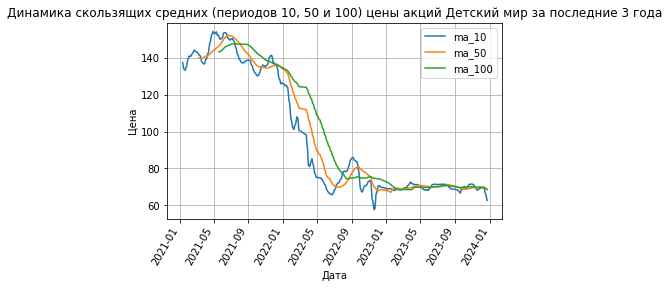

<Figure size 1080x720 with 0 Axes>

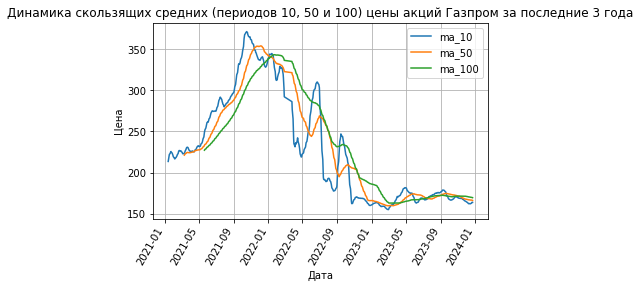

<Figure size 1080x720 with 0 Axes>

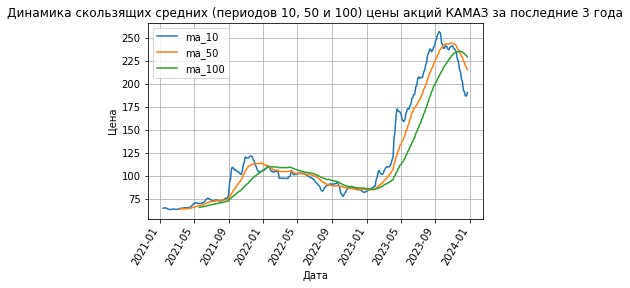

<Figure size 1080x720 with 0 Axes>

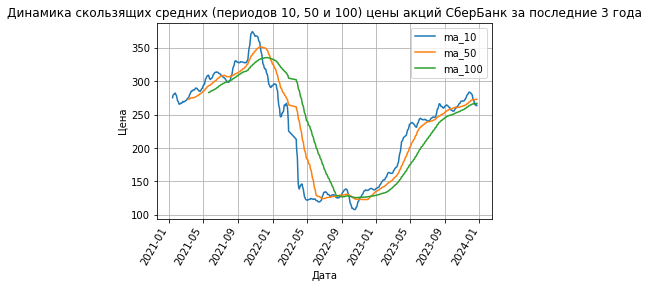

<Figure size 1080x720 with 0 Axes>

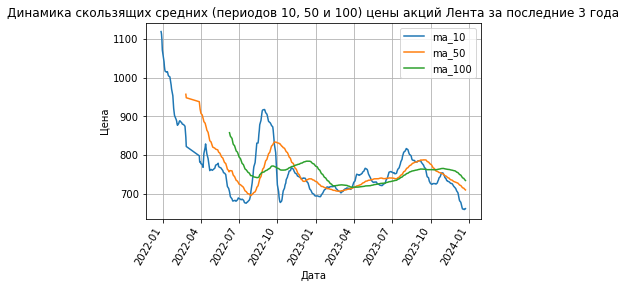

In [354]:
for i, p in enumerate(ticker):
    plt.figure(figsize = (15, 10))
    data = df.query('ticker == @p')
    data.plot (x= 'date', y=['ma_10', 'ma_50', 'ma_100'])
    plt.title(f'Динамика скользящих средних (периодов 10, 50 и 100) цены акций {st_rus[i]} за последние 3 года')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.xticks(rotation=60)
    plt.grid(True)
    plt.show()

##### Что можно сказать, наблюдая за скользящими средними: 
Когда график короткосрочной скользящей средней (например, при использовании окна 10) пересекает график долгосрочной скользящей средней (например, при использовании окна 100) снизу вверх, это сигнализирует о возможности покупки акций трейдером. Аналогично, если происходит пересечение сверху вниз, это может быть сигналом для трейдера о продаже акций.

### Вывод: 
1. Аналируя акции Детского мира, мы можем увидим, что ситуация, когда график короткосрочной скользящей средней пересекает долгосрочную снизу вверх, до марта 2023 года наблюдалась всего около 3 раз, именно в тех ситуацих трейдер был готов купить данные акции. Ситуация же противоположная наблюдалась на графике до марта 2023 года также наблюдалась около 3 раз. После марта 2023 года короктосрочная и долгосрочная скользящие постоянно сменялись местами, то одна выше, то другая.
2. Наблюдая за скользящими средними Газпрома, можно заметить, что они располагаются более скачкообразно, чем, напрмиер, у Детского мира. За данные три года корокосрочная скользящая средняя пересекала долгосрочную сверху вниз около 6 раз, именно в стольких случаях ьтрейдеры готовы были купить акции Газпрома. Противоположнач ситуация за 3 года случалась немного чаще. Трейдеры были готовы продать акции Газпрома около 7 раз.
3. По поводу компании КАМАЗ можно сказать, что его скользящие средние с начала 2023 года значительно выросли. Ситуация, когда трейдеры готовы были купить акции КАМАЗа за 3 года наблюдалась всего 3 раза, противоположная же ситуция наблюдалась 2 раза.
4. У скользящих средних СберБанка наблюдалось пару значительных скачков за данный период. Скачок в росте сначала произошёл в октябре 2021, а затем в сентябре 2023. Ситуация, когда график короткосрочной скользящей средней пересекает долгосрочную снизу вверхнаблюдалась всего 2 раза, противоположная же около 3 раза.
5. Динамика скользящих средних Ленты с начала 2023 года практически не меняется. Ситация, когда трейдер готов был купить данные акции происходила около 3 раз, ситуация, когда трейдер пожелал бы избавиться от этих акций также около 3 раз.

### 7. Постройте в цикле графики объема (volume) для каждого тикера.

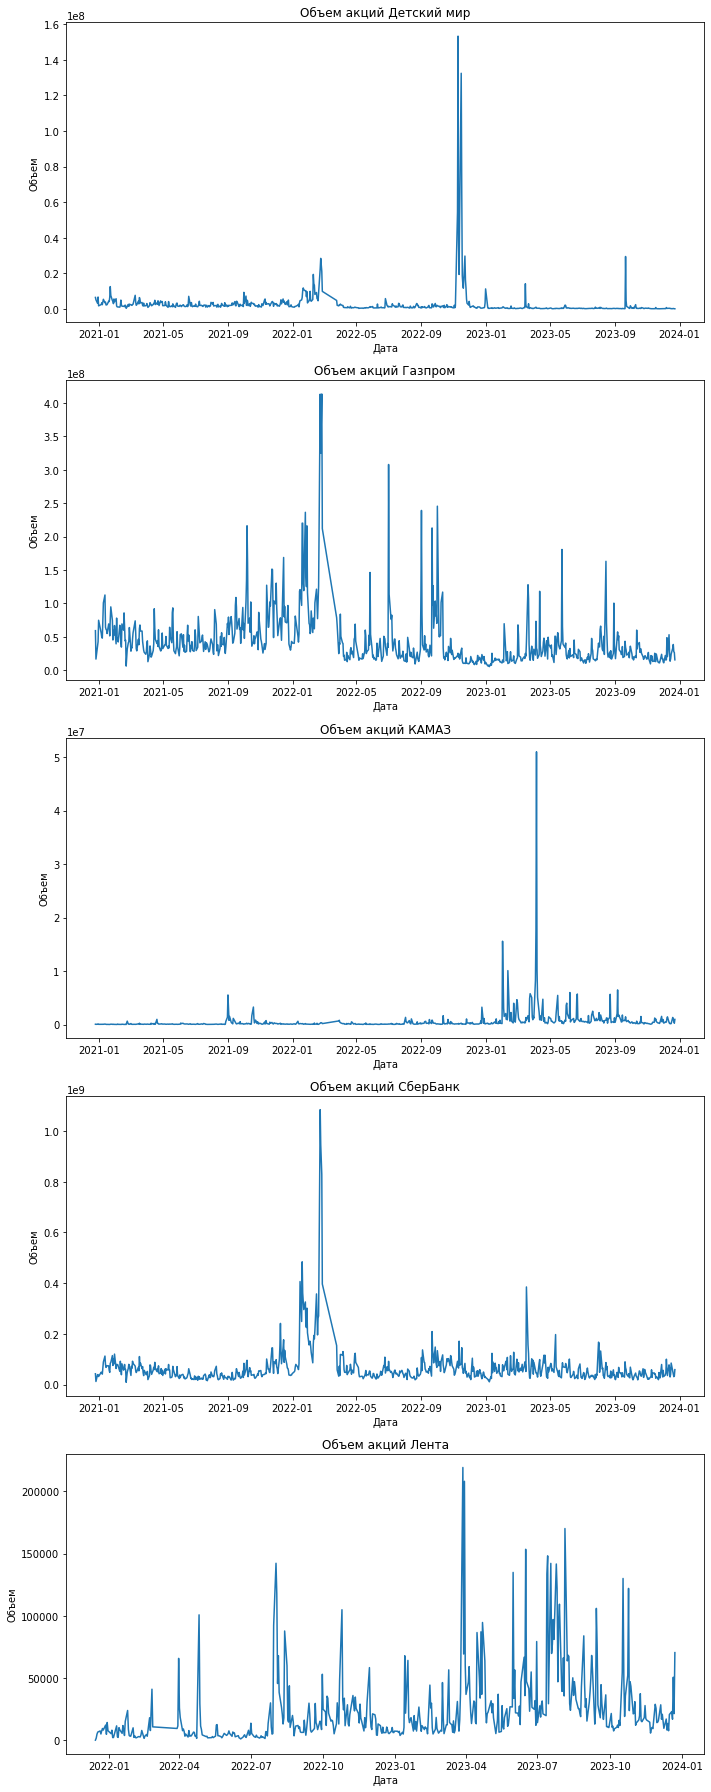

In [355]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 25))

for i, company in enumerate(ticker):
    company_data = df[df['ticker'] == company]
    axes[i].plot(company_data['date'], company_data['vol'])
    axes[i].set_title(f'Объем акций {ticker_2[i]}')
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel('Объем')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

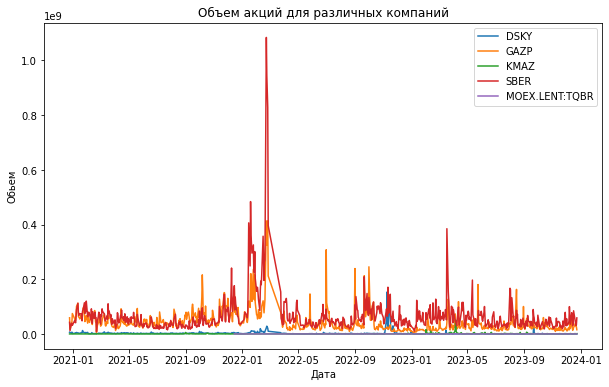

In [356]:
plt.figure(figsize=(10, 6))

for company in ticker:
    company_data = df[df['ticker'] == company]
#построим график
    plt.plot (company_data['date'], company_data['vol'], label=company)
plt.xlabel('Дата')
plt.ylabel('Обьем' )
plt.title('Объем акций для различных компаний')
plt.legend()
plt.show


### Вывод:
1. По представленным данным мы можем сказать, что наибольшими объёмами акций владеют компании СберБанк и Газпром.
2. Максимальный объём акций СберБанка наблюдался в марте 2022 года и составлял около 1 млрд. Максимальный же объём акций Газпрома был также в марте 2022 года и составлял более 400 млн.
3. У остальных компаний дела по объёму обстоят чуть хуже. Самый маленький максимальный объём среди представленных комапний наблюдался у Детского мира в конце 2022 года менее 160 млн.
4. Самый минимальный объём среди предложенных акций наблюдался также у Детского мира и достигал отметки 10 млн, причем ни один рах за последние 3 года.

### 8. Реализуйте в цикле для каждого тикера последовательно: график цены вместе с скользящими средними с периодом 50, 100 и график объема, реализуйте с помощью функции. На вход функция принимает два параметра: тикер и год.

In [357]:
ticker = df['ticker'].unique()
ticker

array(['DSKY', 'GAZP', 'KMAZ', 'SBER', 'MOEX.LENT:TQBR'], dtype=object)

In [358]:
def plot_stock_data(ticker, year):
    company_data = df[(df['ticker'] == ticker) & (df['date'].dt.year == year)].copy()

    #расчетаем скользящиие средние с разными периодами
    company_data['MA_50'] = company_data['close'].rolling(window=50).mean()
    company_data['MA_100'] = company_data['close'].rolling(window=100).mean()

    plt.figure(figsize=(12, 8))

    #построим график цены и скользящих средних
    plt.subplot(2, 1, 1)
    plt.plot(company_data['date'], company_data['close'], label='Цена закрытия')
    plt.plot(company_data['date'], company_data['MA_50'], label='MA 50', linestyle='--')
    plt.plot(company_data['date'], company_data['MA_100'], label='MA 100', linestyle='-.')
    plt.title(f'Цена акций {ticker} в {year}')
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия / MA')
    plt.legend()

    #построим график объема
    plt.subplot(2, 1, 2)
    plt.plot(company_data['date'], company_data['vol'], label='Объем')
    plt.title(f'Объем акций {ticker} в {year}')
    plt.xlabel('Дата')
    plt.ylabel('Объем')
    plt.legend()

    plt.tight_layout()
    plt.show()

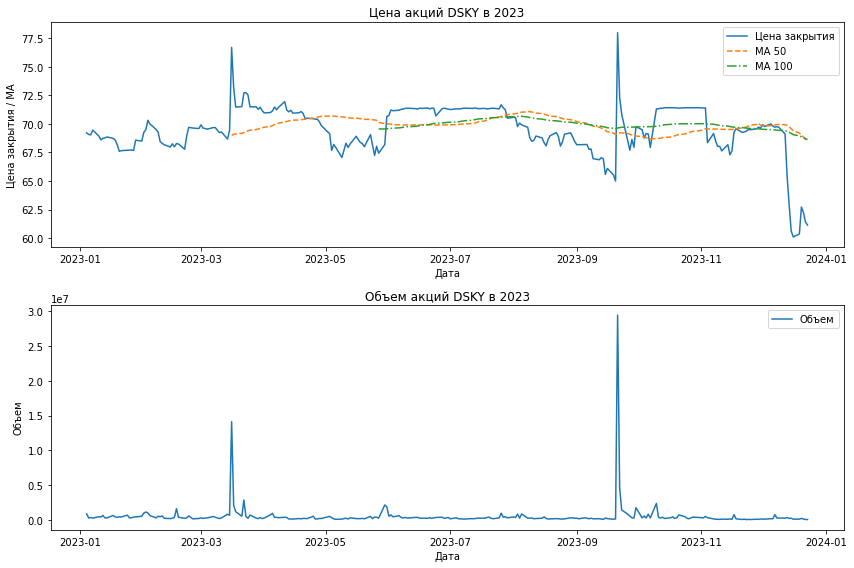

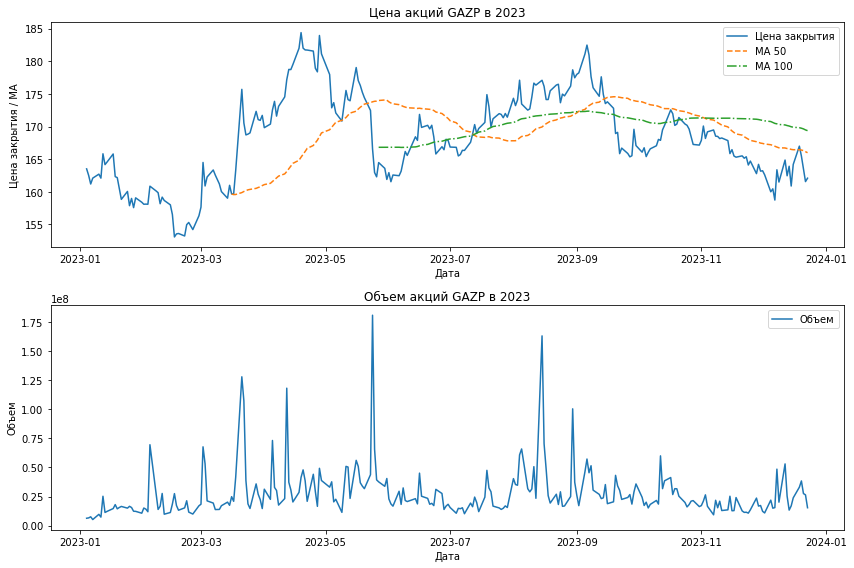

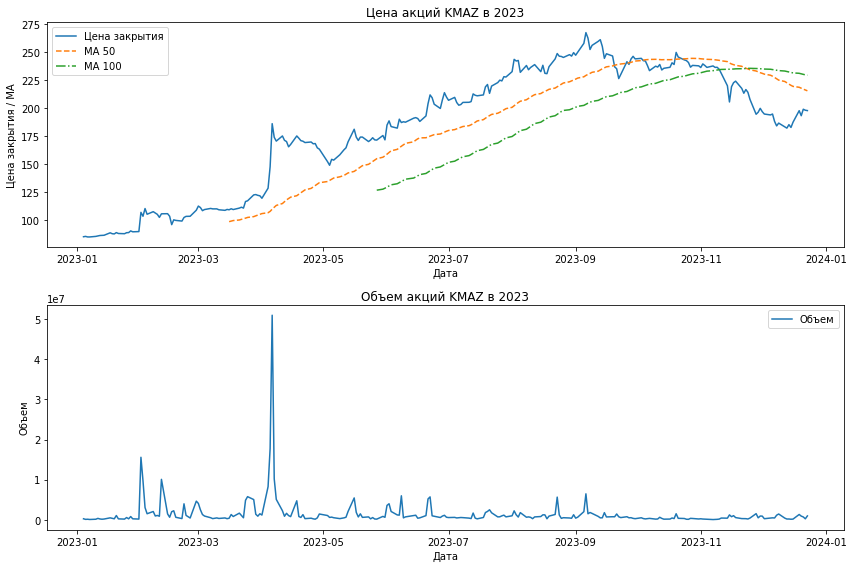

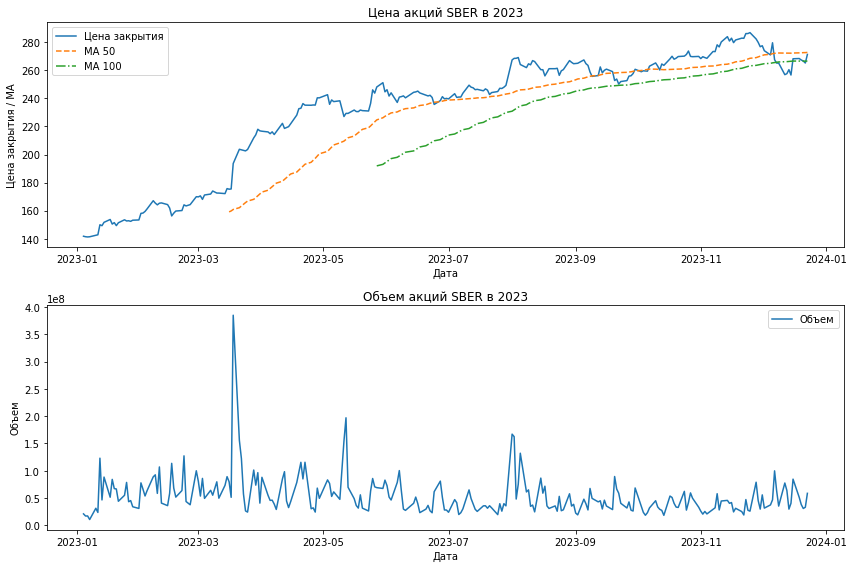

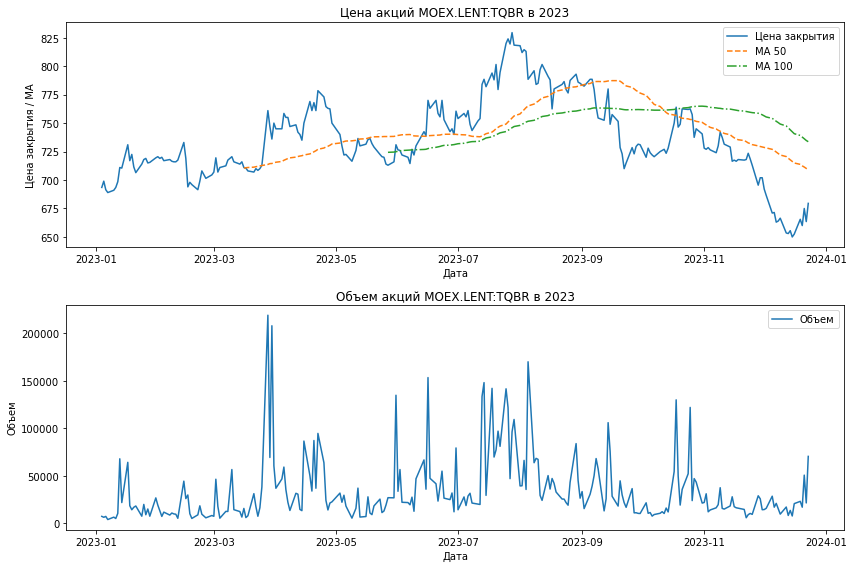

In [359]:
year = 2023  # год

for tick in ticker:
    plot_stock_data(tick, year)

### Вывод: 
1. Таким образом, соединив предыдущие данные, мы можем сказать, что для каких-то акций мы наблюдаем динамику к росту за 2023 году, например, акции СберБанка, КАМАЗ другие же акции сначала 2023 года вроде бы росли в стоимости, но позже стоимость по каким-то причнам начала снижаться (Детский мир, Лента). Не очень равномерно обстоят дела у Газпрома, здесь акции имеют колебания в разные стороны, цена то растет, то снижается. 
2. Из представленных данных в конце 2023 года наименее привлекательными акциями являются акции Детского мира и Ленты. Наиблолее привлекательными для покупки акции Сбербанка, так как наблюдается постепенный рост, а также акции Газпрома, посколько в конце 2023 года находятся на довольно низкой стоимости, а их скачкообразное развитие, может говорить о следующем подъёме в стоимости.

### 9. Добавьте экспоненциальные скользящие средние для каждого тикера с периодом 50.

In [360]:
ticker = df['ticker'].unique()
ticker

array(['DSKY', 'GAZP', 'KMAZ', 'SBER', 'MOEX.LENT:TQBR'], dtype=object)

C:\Users\София\AppData\Local\Temp\ipykernel_12928\2768258626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['EMA'] = company_data['close'].ewm(span=window, adjust=False).mean()


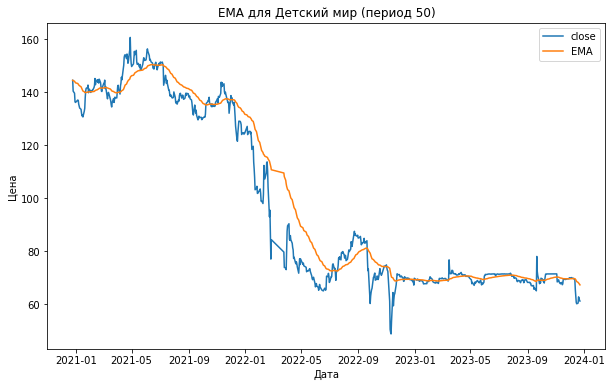

C:\Users\София\AppData\Local\Temp\ipykernel_12928\2768258626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['EMA'] = company_data['close'].ewm(span=window, adjust=False).mean()


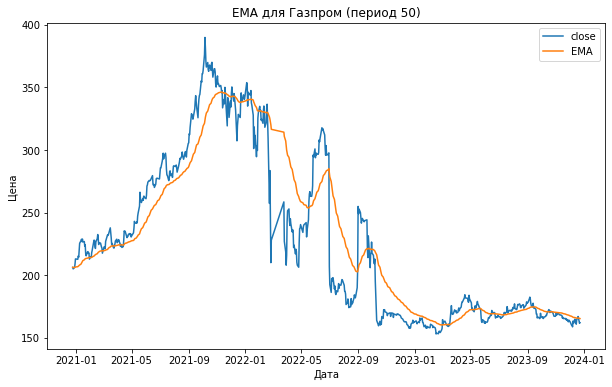

C:\Users\София\AppData\Local\Temp\ipykernel_12928\2768258626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['EMA'] = company_data['close'].ewm(span=window, adjust=False).mean()


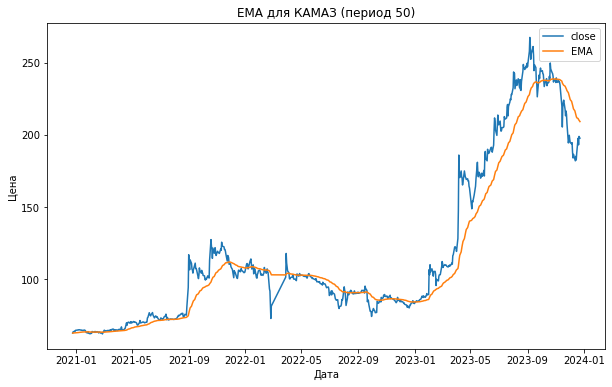

C:\Users\София\AppData\Local\Temp\ipykernel_12928\2768258626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['EMA'] = company_data['close'].ewm(span=window, adjust=False).mean()


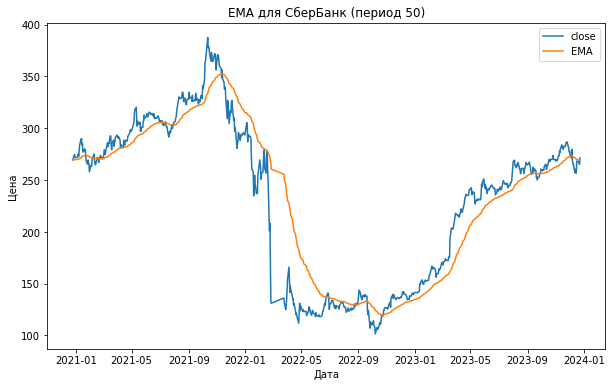

C:\Users\София\AppData\Local\Temp\ipykernel_12928\2768258626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['EMA'] = company_data['close'].ewm(span=window, adjust=False).mean()


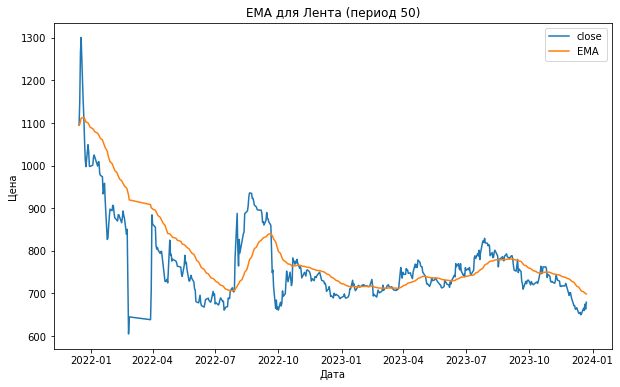

In [361]:
window = 50

for i, tick in enumerate(ticker):
    plt.figure(figsize=(10, 6))
    
    company_data = df[df['ticker'] == tick]
    company_data['EMA'] = company_data['close'].ewm(span=window, adjust=False).mean()
    #строим графики
    plt.plot(company_data['date'], company_data['close'], label='close')
    plt.plot(company_data['date'], company_data['EMA'], label='EMA')
    plt.title(f'EMA для {ticker_2[i]} (период {window})')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.legend()
    plt.show()
    

Так как экспоненциальные скользящие средние (EMA) придают больший вес последним данным, они более реактивны к недавним изменениям цен, чем простые скользящие средние (SMA), что делает их результаты более актуальными и чувствительными. Поэтому метод EMA часто предпочтительнее других методов, таких как кумулятивная скользящая средняя (CMA), благодаря своей временной актуальности.

### 10.Осуществите расчет индикатора RSI.

In [362]:
ticker = df['ticker'].unique()
ticker

array(['DSKY', 'GAZP', 'KMAZ', 'SBER', 'MOEX.LENT:TQBR'], dtype=object)

In [363]:
df = df.groupby('ticker', group_keys = False).apply(lambda x: x.assign(ema_1 = x['difference'].where(x['difference'] > 0, 0).rolling(window=14).mean(),
                                                                       ema_2 = -x['difference'].where(x['difference'] < 0, 0).rolling(window=14).mean()))
df['rs'] = df['ema_1'] / df['ema_2']
df['rsi'] = 100 - 100 / (1+df['rs'])

<Figure size 720x432 with 0 Axes>

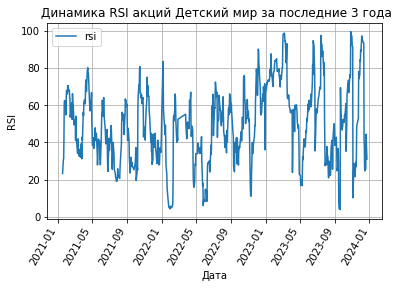

<Figure size 720x432 with 0 Axes>

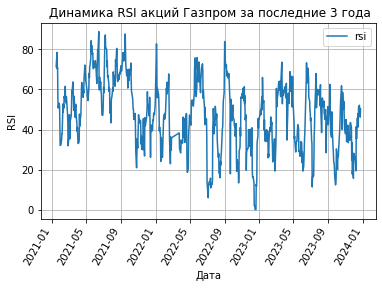

<Figure size 720x432 with 0 Axes>

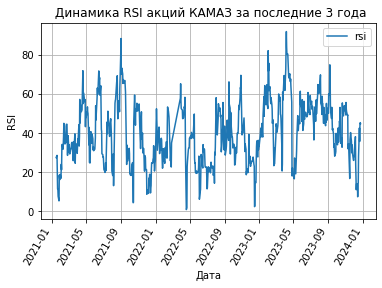

<Figure size 720x432 with 0 Axes>

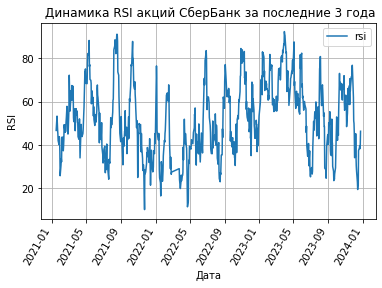

<Figure size 720x432 with 0 Axes>

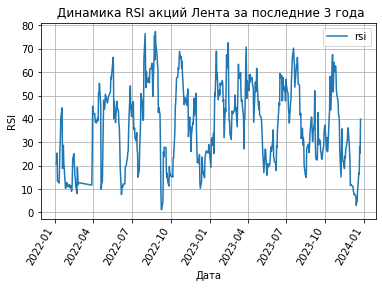

In [364]:
for i, p in enumerate(ticker):
    plt.figure(figsize = (10, 6))
    data = df.query('ticker == @p')
    #строим графики
    data.plot(x='date', y='rsi')
    plt. title(f' Динамика RSI акций {ticker_2[i]} за последние 3 года')
    plt.xlabel('Дата' )
    plt.ylabel ('RSI')
    plt.xticks (rotation=60)
    plt.grid (True)
    plt.show()

Индикатор RSI (Индекс относительной силы) является техническим индикатором, используемым в анализе финансовых рынков, особенно на рынке ценных бумаг. RSI используется для оценки скорости и изменения цен, а также для определения перекупленности или перепроданности актива.

Он измеряет степень, на которую текущие изменения цен актива отклоняются от предыдущих изменений цен за определенный период. Индекс RSI обычно колеблется между 0 и 100. 
Если RSI равен 70 или больше, предполагается, что инструмент перекуплен (ситуация, при которой цены выросли больше, чем ожидалось рынком).
Значение RSI, равное 30 или менее, воспринимается как сигнал о том, что инструмент может быть перепродан (ситуация, при которой цены упали больше, чем ожидалось рынком).

Поэтому, чтобы провести анализ данных графиком нам необходимо нанести на них линии на уровнях 70 и 30, что мы и сделаем в следующем пункте.

### 11.Создайте функцию для вывода графиков: цены, скользящей средней (тип и период определите самостоятельно) и отдельный график для RSI индикатора. На графике с RSI добавьте две красные линии на уровнях 70 и 30. На вход функция принимает два параметра: тикер и год.

In [365]:
#создадим функцию
def plot_stock_data_for_year(ticker, year, window=50):
    
    company_data = df[(df['ticker'] == ticker) & (df['date'].dt.year == year)].copy()
    company_data['MA'] = company_data['close'].rolling(window=window).mean()
    company_data['RSI'] = calculate_rsi(company_data['close'])

 #построим графики
    plt.figure(figsize=(10, 6))

    plt.subplot(3, 1, 1)
    plt.plot(company_data['date'], company_data['close'], label='Цена закрытия')
    plt.title(f'Цены акций {ticker} в {year}')
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(company_data['date'], company_data['MA'], label=f'Скользящая средняя ({window} период)')
    plt.title(f'Скользящая средняя {ticker} в {year}')
    plt.xlabel('Дата')
    plt.ylabel('Скользящая средняя')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(company_data['date'], company_data['RSI'], label='RSI')
    plt.title(f'RSI для {ticker} в {year}')
    plt.xlabel('Дата')
    plt.ylabel('RSI')
    plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
    plt.axhline(y=30, color='r', linestyle='--', label='Oversold (30)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

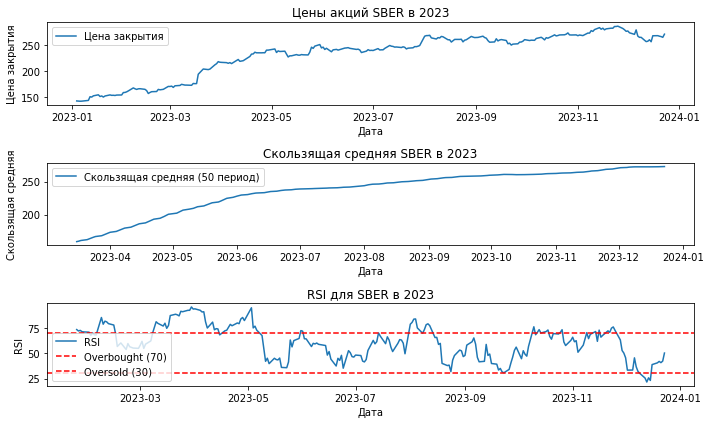

In [366]:
ticker = 'SBER'  # название акции
year = 2023  # год
#выведем функцию с заданными значениями
plot_stock_data_for_year(ticker, year, window=50)

### Вывод: 
По акциям СберБанка мы можем сделать следующий вывод:
1. За 2023 год акции Сбербанка стабильно росли в стоимости.
2. Скользящая средняя направлена вверх и поднимается, это указывает на то, что средняя цена за 2023 год увеличивается, это способствует увеличению спроса на актив и восходящему тренду
3. В период с марта по начало июня RSI достигал отметки выше 70, это говорит нам о том, что идёт некоторая ситуация, при которой цены выросли больше, чем ожидалось рынком и акции могли быть перекуплены. А в конце 2023 года мы наблюдаем ситуацию, когда RSI отпустился ниже отметки 30, а значит что акции могут быть перепроданы (ситуация, при которой цены упали больше, чем ожидалось рынком).


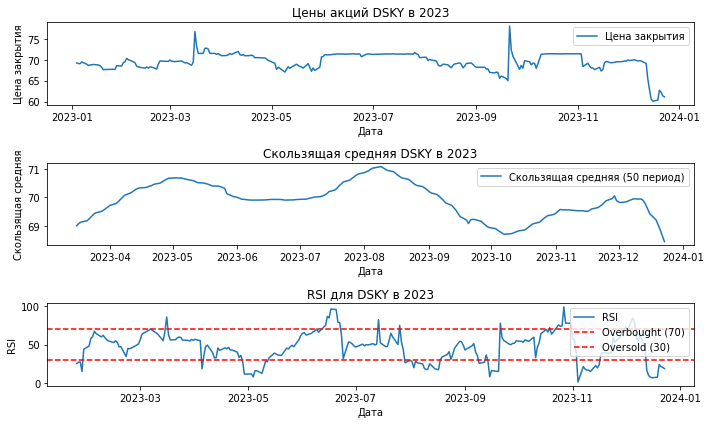

In [367]:
ticker = 'DSKY'  # название акции
year = 2023  # год
#выведем функцию с заданными значениями
plot_stock_data_for_year(ticker, year, window=50)

### Вывод: 
По акциям Детского мира мы можем сделать следующий вывод:
1. За 2023 год наблюдалась боллее мене стабильность в стоимости акций. Всплески роста были лишь в апреле, в октябре, а резкое падение наблюдалось в конце 2023 года.
2. Здесь скользящая средняя то растет, что  указывает на увеличение средней цены актива за 2023 год, то снижается, что свидетельствует о снижении средней цены актива за 2023 год.
3. В апереле, июне, начале ноябре и декабре 2023 года RSI достигал отметки выше 70, это говорит нам о том, что идёт некоторая ситуация, при которой цены выросли больше, чем ожидалось рынком и акции могли быть перекуплены. А в феврале, конце апреля, мае, августе, сентяюре, ноябре и в конце декабря мы наблюдаем ситуацию, когда RSI отпустился ниже отметки 30, а значит что акции могут быть перепроданы (ситуация, при которой цены упали больше, чем ожидалось рынком).

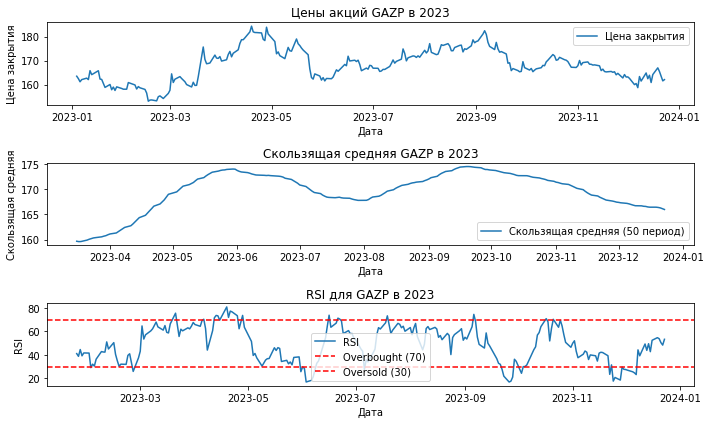

In [368]:
ticker = 'GAZP'  # название акции
year = 2023  # год
#выведем функцию с заданными значениями
plot_stock_data_for_year(ticker, year, window=50)

### Вывод: 
По акциям Газпрома мы можем сделать следующий вывод:
1. За 2023 год наблюдалось скачкообразное поведение Газпрома, они за год колебались в диапозоне от 150 до 185 рублей.
2. О скачкообразных поведениях цены нам говорит и скользящая средняя. Она то растет, что указывает на увеличение средней цены актива за 2023 год, то снижается, что свидетельствует о снижении средней цены актива за 2023 год.
3. В апереле, начале мая, июне, начале августа 2023 года RSI достигал отметки выше 70, это говорит нам о том, что идёт некоторая ситуация, при которой цены выросли больше, чем ожидалось рынком и акции могли быть перекуплены. А в начале марта, начале июня, октябре и декабре мы наблюдаем ситуацию, когда RSI отпустился ниже отметки 30, а значит что акции могут быть перепроданы (ситуация, при которой цены упали больше, чем ожидалось рынком).

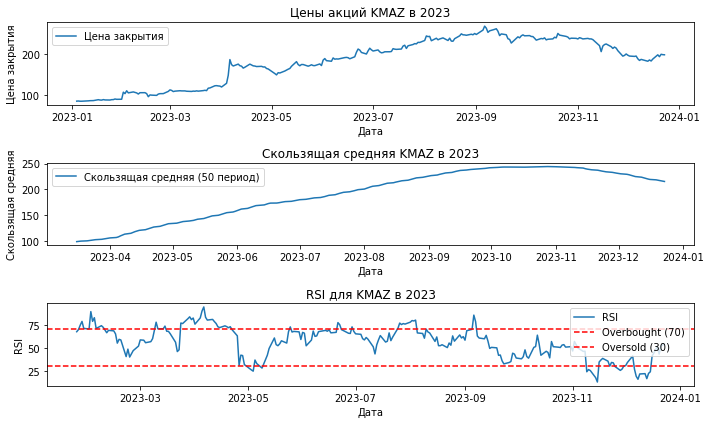

In [369]:
ticker = 'KMAZ'  # название акции
year = 2023  # год
#выведем функцию с заданными значениями
plot_stock_data_for_year(ticker, year, window=50)

### Вывод: 
По акциям КАМАЗа мы можем сделать следующий вывод:
1. За 2023 год акции КАМАЗа значительно росли в стоимости.
2. О росте цены нам говорит и скользящая средняя. Она направлена вверх и поднимается, это указывает на то, что средняя цена за 2023 год увеличивается, это способствует увеличению спроса на актив и восходящему тренду.
3. В феврале, апреле, начале июля, конце сентября 2023 года RSI достигал отметки выше 70, это говорит нам о том, что идёт некоторая ситуация, при которой цены выросли больше, чем ожидалось рынком и акции могли быть перекуплены. А в мае, конце ноября и декабре мы наблюдаем ситуацию, когда RSI отпустился ниже отметки 30, а значит что акции могут быть перепроданы (ситуация, при которой цены упали больше, чем ожидалось рынком).

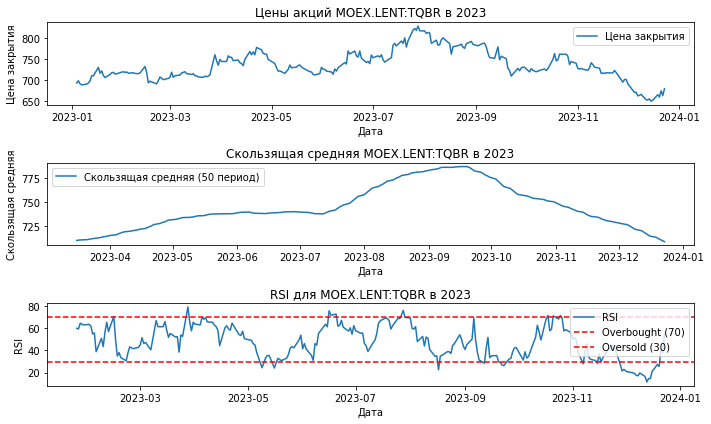

In [370]:
ticker = 'MOEX.LENT:TQBR'  # название акции
year = 2023  # год
#выведем функцию с заданными значениями
plot_stock_data_for_year(ticker, year, window=50)

### Вывод: 
По акциям Ленты мы можем сделать следующий вывод:
1. За 2023 год тоже наблюдалось скачкообразное поведение акций Ленты, они за год колебались в диапозоне от 650 до 825 рублей.
2. О скачкообразных поведениях цены нам говорит и скользящая средняя. Она то растет, что указывает на увеличение средней цены актива за 2023 год, то снижается, что свидетельствует о снижении средней цены актива за 2023 год.
3. В апреле, начале июля, августе 2023 года RSI достигал отметки выше 70, это говорит нам о том, что идёт некоторая ситуация, при которой цены выросли больше, чем ожидалось рынком и акции могли быть перекуплены. А мае, конце августа, декабре мы наблюдаем ситуацию, когда RSI отпустился ниже отметки 30, а значит что акции могут быть перепроданы (ситуация, при которой цены упали больше, чем ожидалось рынком).